In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


# Read Table

In [2]:
customer = pd.read_csv('../input/brazilian-ecommerce/olist_customers_dataset.csv')
orders_detail = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
geolocation = pd.read_csv('../input/brazilian-ecommerce/olist_geolocation_dataset.csv')
products_detail = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('../input/brazilian-ecommerce/olist_sellers_dataset.csv')

# Labeling Churn

In [3]:
#I want to know an 'user' how make a payment so I drop duplicate because some users use methode payments > 2 in an order
payments_no_duplicated = payments.drop_duplicates('order_id', keep = 'first')
payments_no_duplicated = payments_no_duplicated[['order_id']]
payments_no_duplicated

,order_id
0,b81ef226f3fe1789b1e8b2acac839d17
1,a9810da82917af2d9aefd1278f1dcfa0
2,25e8ea4e93396b6fa0d3dd708e76c1bd
3,ba78997921bbcdc1373bb41e913ab953
4,42fdf880ba16b47b59251dd489d4441a
...,...
103881,0406037ad97740d563a178ecc7a2075c
103882,7b905861d7c825891d6347454ea7863f
103883,32609bbb3dd69b3c066a6860554a77bf
103884,b8b61059626efa996a60be9bb9320e10


In [4]:
#Let's convert type data became datetime to better data manipulation

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


In [5]:
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [6]:
# I exclude status order unavailable & canceled
orders_without_canceled_unavailable = orders[(orders['order_status'] != 'unavailable') & (orders['order_status'] != 'canceled')]

#Let's merge table to better understanding with payment table with left join 
orders_merge = orders_without_canceled_unavailable[['order_id', 'customer_id', 'order_purchase_timestamp']].merge(payments_no_duplicated, on = 'order_id', how = 'left')

#Let's change format date in order_purchase_timestamp columns to month-year periode
orders_merge['order_purchase_timestamp'] = pd.to_datetime(orders_merge['order_purchase_timestamp'].dt.strftime('%Y-%m'), format = '%Y-%m')

orders_merge

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-01
...,...,...,...
98202,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-01
98203,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-01
98204,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-01
98205,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-01


In [7]:
#Let's make table churn with join between customer and orders_delivered_merge table
customers_churn = customer[['customer_id', 'customer_unique_id']].merge(orders_merge, on = 'customer_id', how = 'left')

#Sorting date for better understanding
customers_churn.sort_values('order_purchase_timestamp', inplace = True)

#There customers with null value in order_purchase_timestamp column
customers_churn[customers_churn['order_purchase_timestamp'].isnull()]

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,NaN,NaT
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,NaN,NaT
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,NaN,NaT
378,3ba47b09546c2da91ef141efce2d5888,b8c37ee810b38c416022e1c9f51e740c,NaN,NaT
380,cfffbb322333151f8df6398a8c3340db,0dc0731aafd5659410244092b0dc7d65,NaN,NaT
...,...,...,...,...
98746,ef775ae2f3b831b79dd2e9bcf77bfb06,46c0a00dac020d24bfdfbc8b214d54de,NaN,NaT
98786,d9335c099e6943d88ac5f8a7cb418b66,22af178809fa6887af2cc4f7d7bdc0bc,NaN,NaT
99007,2034cc6d6d517007a9ba3e22ba643344,cb47d51801e7379766c5cd8ff623f37f,NaN,NaT
99105,882b44646ab3f186597b1622a9443ff9,639b4096a4e5c96549a9bb495ca4871e,NaN,NaT


In [8]:
#Before I drop it, let's save it on customer_non_active
customer_non_active = customers_churn[customers_churn['order_purchase_timestamp'].isnull()]
customer_non_active.set_index('customer_unique_id', inplace =  True)
customer_non_active

,customer_id,order_id,order_purchase_timestamp
customer_unique_id,,,
233896de79986082f1f479f1f85281cb,f34a6e874087ec1f0e3dab9fdf659c5d,NaN,NaT
0071f46a072a9ae25bbe4438b15efe9c,5bfe800011656c0afb81db64519982db,NaN,NaT
035f60af6e7d7f78470e9443be08d339,b08064e24083fee8fbe8797902b07ecd,NaN,NaT
b8c37ee810b38c416022e1c9f51e740c,3ba47b09546c2da91ef141efce2d5888,NaN,NaT
0dc0731aafd5659410244092b0dc7d65,cfffbb322333151f8df6398a8c3340db,NaN,NaT
...,...,...,...
46c0a00dac020d24bfdfbc8b214d54de,ef775ae2f3b831b79dd2e9bcf77bfb06,NaN,NaT
22af178809fa6887af2cc4f7d7bdc0bc,d9335c099e6943d88ac5f8a7cb418b66,NaN,NaT
cb47d51801e7379766c5cd8ff623f37f,2034cc6d6d517007a9ba3e22ba643344,NaN,NaT


In [9]:
#Let's drop it ustomers with null value in order_purchase_timestamp column
customers_churn.dropna(axis = 0, inplace = True)

#Let's sorting data with better understanding for Python in labeling churn
customers_churn.sort_values(['customer_unique_id', 'order_purchase_timestamp'], inplace = True, ignore_index = True)

In [10]:
#Labeling Process
a = []
for i in range (customers_churn.shape[0] - 1) :
    if customers_churn.loc[i, 'customer_unique_id'] == customers_churn.loc[i+1, 'customer_unique_id'] :
        a.append((customers_churn.loc[i+1,'order_purchase_timestamp'] - customers_churn.loc[i,'order_purchase_timestamp'])/np.timedelta64(1,'M'))
    else :
        a.append((customers_churn.loc[i, 'order_purchase_timestamp'] - customers_churn.loc[i,'order_purchase_timestamp'])/np.timedelta64(1,'M'))

In [11]:
diff = pd.DataFrame(a, columns = ["diff"])
diff = round(diff)
diff.head()

,diff
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [12]:
diff['diff'].value_counts()

0.0     96327
1.0       480
2.0       298
3.0       196
4.0       182
5.0       140
6.0       128
7.0        92
8.0        83
10.0       66
9.0        58
11.0       49
12.0       33
13.0       21
15.0       16
14.0       15
17.0       10
16.0        8
19.0        3
20.0        1
Name: diff, dtype: int64

In [13]:
customers_churn_ = pd.concat([customers_churn, diff], axis=1)
customers_churn_.sort_values(['customer_unique_id', 'order_purchase_timestamp'], inplace = True, ignore_index = True)
customers_churn_.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,diff
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,0.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,0.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,0.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,0.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,0.0


In [14]:
# Numeric 1: Churn 0: Nonchurn
def labeling(df) : 
    if 1 <= df["diff"] <= 3: 
        return 0
    else :
        return 1

#Apply def
customers_churn_["label_churn"] = customers_churn_.apply(labeling, axis = 1)

In [15]:
customers_churn_.isna().sum()

customer_id                 0
customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
diff                        1
label_churn                 0
dtype: int64

In [16]:
#There a customer with null value in a order_purchase so I fill it with 0
customers_churn_.fillna(0, inplace = True)

In [17]:
customers_churn_final = customers_churn_.loc[:, customers_churn_.columns != 'diff']
customers_churn_final

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1
...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1


In [18]:
customers_churn_final['label_churn'].value_counts()

1    97233
0      974
Name: label_churn, dtype: int64

There are: \
Customer churn (1): 97233 \
Customer churn (0): 974

# Feature Engineering, Feature Selection & Assesment:

## 1. qty_item Feature

In [19]:
orders_detail_qty = orders_detail.groupby(['order_id'], as_index = False).agg({'order_item_id':'count'})
orders_detail_qty.rename(columns ={'order_item_id':'qty_item'}, inplace = True)

In [20]:
customers_churn_final1 = customers_churn_final.merge(orders_detail_qty, on = 'order_id', how = 'left')
customers_churn_final1

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,qty_item
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,1.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,1.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,1.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,1.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,1.0
...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,2.0
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,1.0
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,1.0
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,1.0


In [21]:
customers_churn_final1['qty_item'].value_counts(normalize = True, sort = True)

1.0     0.900600
2.0     0.076264
3.0     0.013432
4.0     0.005122
5.0     0.002006
6.0     0.001986
7.0     0.000224
8.0     0.000081
10.0    0.000081
12.0    0.000051
11.0    0.000041
9.0     0.000031
15.0    0.000020
14.0    0.000020
20.0    0.000020
21.0    0.000010
13.0    0.000010
Name: qty_item, dtype: float64

In [22]:
customers_churn_final1['qty_item'].fillna(customers_churn_final1['qty_item'].median(), inplace = True)

In [23]:
def label_qty_item(x):
    if x == 1:
        return 'little'
    elif x == 2:
        return 'standard'
    else:
        return 'much'

customers_churn_final1['label_qty_item'] = customers_churn_final1['qty_item'].apply(label_qty_item)

In [24]:
asess_1 = pd.crosstab(customers_churn_final1["label_qty_item"],customers_churn_final1["label_churn"], margins=True, margins_name="Total")
asess_1

label_churn,0,1,Total
label_qty_item,,,
little,837,87609,88446
much,44,2228,2272
standard,93,7396,7489
Total,974,97233,98207


In [25]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

asess_1["%nonevent"] = asess_1.apply(nonevent, axis = 1)
asess_1["%event"] = asess_1.apply(event, axis = 1)

asess_1["WoE"] = np.log(asess_1["%event"]/asess_1["%nonevent"])
asess_1["IV"] = asess_1["WoE"]*(asess_1["%event"] - asess_1["%nonevent"])

asess_1["IV"].sum() # Weak for Predictor

0.02149881982029361

## 2. total_money_spent Feature

In [26]:
payments.loc[payments['payment_type'] == 'voucher', 'payment_value'] = 0
payments_groupby = payments.groupby(['order_id'], as_index = False).agg({'payment_value':'sum'})

payments_groupby.rename(columns = {'payment_value':'total_money_spent'}, inplace = True)
payments_groupby

,order_id,total_money_spent
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


In [27]:
customers_churn_final2 = customers_churn_final.merge(payments_groupby, on = 'order_id', how = 'left')
customers_churn_final2

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,total_money_spent
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,141.90
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,27.19
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,86.22
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,43.62
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,196.89
...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,2067.42
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,84.58
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,112.46
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,133.69


In [28]:
customers_churn_final2['total_money_spent'].value_counts(normalize = True, sort = True)

0.00       0.015630
77.57      0.002505
73.34      0.001629
35.00      0.001578
116.94     0.001303
             ...   
241.95     0.000010
468.80     0.000010
249.90     0.000010
672.93     0.000010
2067.42    0.000010
Name: total_money_spent, Length: 27868, dtype: float64

In [29]:
customers_churn_final2['total_money_spent'].describe()

count    98206.000000
mean       156.703894
std        218.929172
min          0.000000
25%         58.620000
50%        102.665000
75%        174.510000
max      13664.080000
Name: total_money_spent, dtype: float64

In [30]:
customers_churn_final2['total_money_spent'].median()

102.66499999999999

In [31]:
def label_total_money_spent(x):
    if x < 57:
        return 'low'
    elif x < 102:
        return 'standard'
    else:
        return 'too high'

customers_churn_final2['label_total_money_spent'] = customers_churn_final2['total_money_spent'].apply(label_total_money_spent)

In [32]:
asess_2 = pd.crosstab(customers_churn_final2["label_total_money_spent"],customers_churn_final2["label_churn"], margins=True, margins_name="Total")
asess_2

label_churn,0,1,Total
label_total_money_spent,,,
low,252,23125,23377
standard,218,25142,25360
too high,504,48966,49470
Total,974,97233,98207


In [33]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

    
asess_2["%nonevent"] = asess_2.apply(nonevent, axis = 1)
asess_2["%event"] = asess_2.apply(event, axis = 1)

In [34]:
asess_2["WoE"] = np.log(asess_2["%event"]/asess_2["%nonevent"])
asess_2["IV"] = asess_2["WoE"]*(asess_2["%event"] - asess_2["%nonevent"])


asess_2["IV"].sum() #Useless for Predictor

0.0071528115372885386

## 3. time_to_verify_payment Feature

In [35]:
orders_verify_payment = orders_without_canceled_unavailable[['order_id', 'customer_id', 'order_purchase_timestamp', 'order_approved_at']]

orders_verify_payment['order_approved_at'] = pd.to_datetime(orders_verify_payment['order_approved_at'])
orders_verify_payment['order_purchase_timestamp'] = pd.to_datetime(orders_verify_payment['order_purchase_timestamp'])

orders_verify_payment['time_to_verify_payment'] = orders_verify_payment['order_approved_at'] - orders_verify_payment['order_purchase_timestamp']
orders_verify_payment = orders_verify_payment[['order_id', 'customer_id', 'time_to_verify_payment']]

orders_verify_payment['time_to_verify_payment'] = orders_verify_payment['time_to_verify_payment'].dt.days * 24
orders_verify_payment

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,order_id,customer_id,time_to_verify_payment
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,24.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,0.0
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,0.0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,0.0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,0.0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,0.0


In [36]:
customers_churn_final3 = customers_churn_final.merge(orders_verify_payment,on = 'order_id', how = 'left')
customers_churn_final3

,customer_id_x,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_id_y,time_to_verify_payment
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,fadbb3709178fc513abc1b2670aa1ad2,0.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,4cb282e167ae9234755102258dd52ee8,0.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,9b3932a6253894a02c1df9d19004239f,0.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,914991f0c02ef0843c0e7010c819d642,0.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,47227568b10f5f58a524a75507e6992c,0.0
...,...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,74be082247cd677a147d83ee670e9d53,0.0
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,0ecf8e0a08148af0bf313184f167670a,0.0
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,27f584b0f1dc4e610065c240f68b6be0,0.0
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,832a3b0254347d409512ae92eaf154a6,0.0


In [37]:
customers_churn_final3['time_to_verify_payment'].value_counts(normalize = True, sort = True)

0.0       0.824928
24.0      0.123365
48.0      0.029189
72.0      0.014981
96.0      0.003962
120.0     0.002536
144.0     0.000316
168.0     0.000153
288.0     0.000153
192.0     0.000122
240.0     0.000122
264.0     0.000051
216.0     0.000031
552.0     0.000020
720.0     0.000020
312.0     0.000020
384.0     0.000010
1440.0    0.000010
768.0     0.000010
Name: time_to_verify_payment, dtype: float64

In [38]:
customers_churn_final3['time_to_verify_payment'].describe()

count    98188.000000
mean         6.371777
std         18.325732
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1440.000000
Name: time_to_verify_payment, dtype: float64

In [39]:
customers_churn_final3['time_to_verify_payment'].median()

0.0

In [40]:
def label_time_to_verify_payment(x):
    if x == 0:
        return 'fast'
    elif x <= 6:
        return 'standard'
    else:
        return 'slow'

customers_churn_final3['label_time_to_verify_payment'] = customers_churn_final3['time_to_verify_payment'].apply(label_time_to_verify_payment)

In [41]:
asess_3 = pd.crosstab(customers_churn_final3["label_time_to_verify_payment"],customers_churn_final3["label_churn"], margins=True, margins_name="Total")
asess_3

label_churn,0,1,Total
label_time_to_verify_payment,,,
fast,790,80208,80998
slow,184,17025,17209
Total,974,97233,98207


In [42]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

    
asess_3["%nonevent"] = asess_3.apply(nonevent, axis = 1)
asess_3["%event"] = asess_3.apply(event, axis = 1)

In [43]:
asess_3["WoE"] = np.log(asess_3["%event"]/asess_3["%nonevent"])
asess_3["IV"] = asess_3["WoE"]*(asess_3["%event"] - asess_3["%nonevent"])


asess_3["IV"].sum() #Useless for Predictor

0.001282798914018398

## 4. time_to_delivered Feature

In [44]:
orders_time_delivered = orders_without_canceled_unavailable[['customer_id', 'order_id', 'order_delivered_carrier_date', 'order_delivered_customer_date']]
orders_time_delivered

,customer_id,order_id,order_delivered_carrier_date,order_delivered_customer_date
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02
...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-10 11:18:03,2017-03-17 15:08:01
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-07 23:22:42,2018-02-28 17:37:56
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-28 20:52:26,2017-09-21 11:24:17
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-12 15:35:03,2018-01-25 23:32:54


In [45]:
orders_time_delivered['order_delivered_carrier_date'] = pd.to_datetime(orders_time_delivered['order_delivered_carrier_date'])
orders_time_delivered['order_delivered_customer_date'] = pd.to_datetime(orders_time_delivered['order_delivered_customer_date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
orders_time_delivered['time_to_delivered'] = orders_time_delivered['order_delivered_customer_date'] - orders_time_delivered['order_delivered_carrier_date']
orders_time_delivered

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_id,order_id,order_delivered_carrier_date,order_delivered_customer_date,time_to_delivered
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,6 days 01:30:13
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,12 days 00:56:45
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,9 days 04:16:29
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,9 days 10:48:43
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,1 days 22:30:28
...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-10 11:18:03,2017-03-17 15:08:01,7 days 03:49:58
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-07 23:22:42,2018-02-28 17:37:56,20 days 18:15:14
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-28 20:52:26,2017-09-21 11:24:17,23 days 14:31:51
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-12 15:35:03,2018-01-25 23:32:54,13 days 07:57:51


In [47]:
orders_time_delivered['time_to_delivered'] = orders_time_delivered['time_to_delivered'].dt.days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
orders_time_delivered = orders_time_delivered[['customer_id', 'order_id', 'time_to_delivered']]
orders_time_delivered

,customer_id,order_id,time_to_delivered
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,6.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,12.0
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,9.0
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,9.0
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,1.0
...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,7.0
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,20.0
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,23.0
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,13.0


In [49]:
customers_churn_final4 = customers_churn_final.merge(orders_time_delivered, on = 'order_id', how = 'left')
customers_churn_final4

,customer_id_x,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_id_y,time_to_delivered
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,fadbb3709178fc513abc1b2670aa1ad2,4.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,4cb282e167ae9234755102258dd52ee8,1.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,9b3932a6253894a02c1df9d19004239f,23.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,914991f0c02ef0843c0e7010c819d642,19.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,47227568b10f5f58a524a75507e6992c,11.0
...,...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,74be082247cd677a147d83ee670e9d53,12.0
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,0ecf8e0a08148af0bf313184f167670a,19.0
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,27f584b0f1dc4e610065c240f68b6be0,14.0
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,832a3b0254347d409512ae92eaf154a6,10.0


In [50]:
customers_churn_final4['time_to_delivered'].describe()

count    96469.000000
mean         8.878054
std          8.745881
min        -17.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        205.000000
Name: time_to_delivered, dtype: float64

In [51]:
customers_churn_final4['time_to_delivered'].value_counts(normalize = True).head(20)

6.0     0.093875
7.0     0.088588
1.0     0.081695
5.0     0.081632
3.0     0.071422
4.0     0.067763
8.0     0.059076
2.0     0.056516
9.0     0.044408
10.0    0.039287
11.0    0.035773
13.0    0.034021
12.0    0.032767
14.0    0.029056
0.0     0.027822
15.0    0.019115
16.0    0.014730
17.0    0.012698
20.0    0.012139
18.0    0.011237
Name: time_to_delivered, dtype: float64

In [52]:
customers_churn_final4['time_to_delivered'].median()

7.0

In [53]:
def label_time_to_delivered(x):
    if x < 4:
        return 'fast'
    elif x < 7:
        return 'standard'
    else:
        return 'too slow'
    
customers_churn_final4['label_time_to_delivered'] = customers_churn_final4['time_to_delivered'].apply(label_time_to_delivered)

In [54]:
asess_4 = pd.crosstab(customers_churn_final4["label_time_to_delivered"], customers_churn_final4["label_churn"], margins = True, margins_name = 'Total')
asess_4

label_churn,0,1,Total
label_time_to_delivered,,,
fast,236,22694,22930
standard,229,23239,23468
too slow,509,51300,51809
Total,974,97233,98207


In [55]:
def nonevent(df) : 
    return (df[0]/953)
def event(df) : 
    return (df[1]/95524)

asess_4["%nonevent"] = asess_4.apply(nonevent, axis = 1)
asess_4["%event"] = asess_4.apply(event, axis = 1)

In [56]:
asess_4["WoE"] = np.log(asess_4["%event"]/asess_4["%nonevent"])
asess_4["IV"] = asess_4["WoE"]*(asess_4["%event"] - asess_4["%nonevent"])

asess_4["IV"].sum() # Useless for Predictor

0.000487434243860036

## 5. median_review_score Feature

In [57]:
reviews_merge = orders_detail.merge(products_detail[['product_id', 'product_category_name']], on = 'product_id', how = 'left') \
                    .merge(reviews, on = 'order_id', how = 'right')
reviews_merge.sort_values(['review_creation_date', 'review_answer_timestamp'], inplace = True)

# Because in table there weird event where a customer_id can give > 1 ratings on same product and seller so I drop it
reviews_merge.drop_duplicates(['order_id', 'product_id', 'seller_id'], keep = 'last', inplace = True)

reviews_merge = orders_without_canceled_unavailable[['order_id', 'customer_id']].merge(reviews_merge[['order_id', 'review_score']], on = 'order_id', how = 'left')

#There user did not give review yet after status delivered so I fill null value with the modus
reviews_merge['review_score'].fillna(5, inplace = True)

#There users have >1 order_id so I groupby to get median_score each customer_id
reviews_merge = reviews_merge.groupby(['order_id', 'customer_id'], as_index = False).agg({'review_score':'median'})
reviews_merge.rename(columns = {'review_score':'median_review_score'}, inplace = True)

reviews_merge
#Table Ok

,order_id,customer_id,median_review_score
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,5.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,4.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,5.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,5.0
...,...,...,...
98202,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,5.0
98203,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,5.0
98204,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,5.0
98205,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,5.0


In [58]:
customers_churn_final5 = customers_churn_final.merge(reviews_merge, on = 'order_id', how = 'left')
customers_churn_final5

,customer_id_x,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_id_y,median_review_score
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,fadbb3709178fc513abc1b2670aa1ad2,5.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,4cb282e167ae9234755102258dd52ee8,4.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,9b3932a6253894a02c1df9d19004239f,3.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,914991f0c02ef0843c0e7010c819d642,4.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,47227568b10f5f58a524a75507e6992c,5.0
...,...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,74be082247cd677a147d83ee670e9d53,5.0
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,0ecf8e0a08148af0bf313184f167670a,4.0
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,27f584b0f1dc4e610065c240f68b6be0,5.0
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,832a3b0254347d409512ae92eaf154a6,5.0


In [59]:
customers_churn_final5['median_review_score'].value_counts(normalize = True)

5.0    0.586852
4.0    0.193459
1.0    0.106744
3.0    0.081970
2.0    0.030975
Name: median_review_score, dtype: float64

In [60]:
def label_review_score(x):
    if x < 3:
        return 'disappointed'
    elif x <= 4:
        return 'hapy'
    else:
        return 'so happy'

customers_churn_final5['label_review_score'] = customers_churn_final5['median_review_score'].apply(label_review_score)

In [61]:
asess_5 = pd.crosstab(customers_churn_final5["label_review_score"], customers_churn_final5["label_churn"], margins=True, margins_name="Total")
asess_5

label_churn,0,1,Total
label_review_score,,,
disappointed,109,13416,13525
hapy,242,26807,27049
so happy,623,57010,57633
Total,974,97233,98207


In [62]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

    
asess_5["%nonevent"] = asess_5.apply(nonevent, axis = 1)
asess_5["%event"] = asess_5.apply(event, axis = 1)

In [63]:
asess_5["WoE"] = np.log(asess_5["%event"]/asess_5["%nonevent"])
asess_5["IV"] = asess_5["WoE"]*(asess_5["%event"] - asess_5["%nonevent"])


asess_5["IV"].sum() #Useless for Predictor

0.012930940271774157

## 6. order_same_state Feature

In [64]:
orders_seller = orders_detail.groupby(['order_id', 'seller_id'], as_index = False).agg({'order_item_id':'count'})
orders_seller

,order_id,seller_id,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,1
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,1
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,1
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,1
...,...,...,...
100005,fffc94f6ce00a00581880bf54a75a037,b8bc237ba3788b23da09c0f1f3a3288c,1
100006,fffcd46ef2263f404302a634eb57f7eb,f3c38ab652836d21de61fb8314b69182,1
100007,fffce4705a9662cd70adb13d4a31832d,c3cfdc648177fdbbbb35635a37472c53,1
100008,fffe18544ffabc95dfada21779c9644f,2b3e4a2a3ea8e01938cabda2a3e5cc79,1


In [65]:
orders_seller_merge = orders_seller.merge(sellers[['seller_id', 'seller_state']], how = 'left', on = 'seller_id')
orders_seller_merge

,order_id,seller_id,order_item_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,1,SP
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,1,SP
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,1,MG
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,1,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,1,PR
...,...,...,...,...
100005,fffc94f6ce00a00581880bf54a75a037,b8bc237ba3788b23da09c0f1f3a3288c,1,SC
100006,fffcd46ef2263f404302a634eb57f7eb,f3c38ab652836d21de61fb8314b69182,1,SP
100007,fffce4705a9662cd70adb13d4a31832d,c3cfdc648177fdbbbb35635a37472c53,1,PR
100008,fffe18544ffabc95dfada21779c9644f,2b3e4a2a3ea8e01938cabda2a3e5cc79,1,SP


In [66]:
customers_churn_final_state = customers_churn_final.merge(customer[['customer_id', 'customer_state']], on = 'customer_id', how = 'left')
customers_churn_final_state

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_state
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,SP
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,SP
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,SC
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,PA
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,SP
...,...,...,...,...,...,...
98202,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,PE
98203,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,BA
98204,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,MT
98205,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,ES


In [67]:
customers_churn_final_state = customers_churn_final_state.merge(orders_seller_merge[['order_id', 'seller_state']], on = 'order_id', how = 'left')
customers_churn_final_state

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_state,seller_state
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,SP,SP
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,SP,SP
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,SC,SP
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,PA,SP
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,SP,SP
...,...,...,...,...,...,...,...
99545,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,PE,SP
99546,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,BA,SP
99547,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,MT,MG
99548,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,ES,SP


In [68]:
cust_same_state =customers_churn_final_state[customers_churn_final_state['customer_state'] == customers_churn_final_state['seller_state']]
cust_same_state['order_same_state'] = 1
cust_same_state

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_state,seller_state,order_same_state
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,SP,SP,1
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,SP,SP,1
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,SP,SP,1
5,4a913a170c26e3c8052ed0202849b5a8,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-01,1,SP,SP,1
6,d2509c13692836fc0449e88cf9eb4858,00050ab1314c0e55a6ca13cf7181fecf,d0028facea13f508e880202d7097a5a1,2018-04-01,1,SP,SP,1
...,...,...,...,...,...,...,...,...
99521,1a5dca881b4fc9ed776930b3dc9ccfe0,ffeb904468642a1ce663a322629801cb,cab5ff5f1347330a7576a8aa80bd1774,2018-06-01,1,MG,MG,1
99525,8b7ab6f3bd953bf7839099fffdbfb086,ffecceca389973ef16660d58696f281e,7113e8344293a6a03453110d67c7f533,2018-04-01,1,SP,SP,1
99528,fd3129fbbc0767919a5d42cf03525ec2,ffee94d548cef05b146d825a7648dab4,6227965ecb8a92f39dae66cf5f09736c,2018-07-01,1,SP,SP,1
99529,df72728563c0a348eed0e450e9e8c2b7,ffeefd086fc667aaf6595c8fe3d22d54,f9a6aec1708cd20b564a6b2a29ed2290,2017-09-01,1,RJ,RJ,1


In [69]:
cust_diff_state =customers_churn_final_state[customers_churn_final_state['customer_state'] != customers_churn_final_state['seller_state']]
cust_diff_state['order_same_state'] = 0
cust_diff_state

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_state,seller_state,order_same_state
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,SC,SP,0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,PA,SP,0
7,a81ebb9b32f102298c0c89635b4b3154,00053a61a98854899e70ed204dd4bafe,44e608f2db00c74a1fe329de44416a4e,2018-02-01,1,PR,SP,0
8,3b37fb626fdf46cd99d37ec62afa88ff,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-01,1,RJ,MG,0
9,c59e8ff99836e90d8b457d4122dc34e9,0005ef4cd20d2893f0d9fbd94d3c0d97,01b330808c5819a6a3cb79b72f0b8288,2018-03-01,1,MA,RJ,0
...,...,...,...,...,...,...,...,...
99545,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,PE,SP,0
99546,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,BA,SP,0
99547,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,MT,MG,0
99548,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,ES,SP,0


In [70]:
customers_churn_final6 = pd.concat([cust_same_state, cust_diff_state], ignore_index = True)
customers_churn_final6

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_state,seller_state,order_same_state
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,SP,SP,1
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,SP,SP,1
2,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,SP,SP,1
3,4a913a170c26e3c8052ed0202849b5a8,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-01,1,SP,SP,1
4,d2509c13692836fc0449e88cf9eb4858,00050ab1314c0e55a6ca13cf7181fecf,d0028facea13f508e880202d7097a5a1,2018-04-01,1,SP,SP,1
...,...,...,...,...,...,...,...,...
99545,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,PE,SP,0
99546,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,BA,SP,0
99547,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,MT,MG,0
99548,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,ES,SP,0


In [71]:
asess_6 = pd.crosstab(customers_churn_final6["order_same_state"], customers_churn_final6["label_churn"], margins=True, margins_name="Total")
asess_6

label_churn,0,1,Total
order_same_state,,,
0,623,63210,63833
1,370,35347,35717
Total,993,98557,99550


In [72]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

    
asess_6["%nonevent"] = asess_6.apply(nonevent, axis = 1)
asess_6["%event"] = asess_6.apply(event, axis = 1)

In [73]:
asess_6["WoE"] = np.log(asess_6["%event"]/asess_6["%nonevent"])
asess_6["IV"] = asess_6["WoE"]*(asess_6["%event"] - asess_6["%nonevent"])


asess_6["IV"].sum() #Useless for Predictor

0.0009228425221194615

## 7. Respons_to_reviews

In [74]:
reviews_respons = reviews_merge.merge(reviews[['order_id', 'review_creation_date', 'review_answer_timestamp']], on = 'order_id', how = 'left')
reviews_respons

,order_id,customer_id,median_review_score,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,5.0,2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,4.0,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,5.0,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,4.0,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,5.0,2017-03-02 00:00:00,2017-03-03 10:54:59
...,...,...,...,...,...
98747,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,5.0,2018-05-11 00:00:00,2018-05-14 12:53:47
98748,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,5.0,2018-07-24 00:00:00,2018-07-25 09:25:29
98749,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,5.0,2017-10-29 00:00:00,2017-10-29 21:33:52
98750,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,5.0,2017-08-17 00:00:00,2017-08-18 12:24:05


In [75]:
reviews_respons['review_answer_timestamp'] = pd.to_datetime(reviews_respons['review_answer_timestamp'])
reviews_respons['review_creation_date'] = pd.to_datetime(reviews_respons['review_creation_date'])

In [76]:
reviews_respons['respons_to_reviews'] = reviews_respons['review_answer_timestamp'] - reviews_respons['review_creation_date']
reviews_respons

,order_id,customer_id,median_review_score,review_creation_date,review_answer_timestamp,respons_to_reviews
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,5.0,2017-09-21,2017-09-22 10:57:03,1 days 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,4.0,2017-05-13,2017-05-15 11:34:13,2 days 11:34:13
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,5.0,2018-01-23,2018-01-23 16:06:31,0 days 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,4.0,2018-08-15,2018-08-15 16:39:01,0 days 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,5.0,2017-03-02,2017-03-03 10:54:59,1 days 10:54:59
...,...,...,...,...,...,...
98747,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,5.0,2018-05-11,2018-05-14 12:53:47,3 days 12:53:47
98748,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,5.0,2018-07-24,2018-07-25 09:25:29,1 days 09:25:29
98749,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,5.0,2017-10-29,2017-10-29 21:33:52,0 days 21:33:52
98750,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,5.0,2017-08-17,2017-08-18 12:24:05,1 days 12:24:05


In [77]:
reviews_respons['respons_to_reviews'] = reviews_respons['respons_to_reviews'].dt.days * 24
reviews_respons

,order_id,customer_id,median_review_score,review_creation_date,review_answer_timestamp,respons_to_reviews
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,5.0,2017-09-21,2017-09-22 10:57:03,24.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,4.0,2017-05-13,2017-05-15 11:34:13,48.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,5.0,2018-01-23,2018-01-23 16:06:31,0.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,4.0,2018-08-15,2018-08-15 16:39:01,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,5.0,2017-03-02,2017-03-03 10:54:59,24.0
...,...,...,...,...,...,...
98747,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,5.0,2018-05-11,2018-05-14 12:53:47,72.0
98748,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,5.0,2018-07-24,2018-07-25 09:25:29,24.0
98749,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,5.0,2017-10-29,2017-10-29 21:33:52,0.0
98750,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,5.0,2017-08-17,2017-08-18 12:24:05,24.0


In [78]:
customers_churn_final7 = customers_churn_final.merge(reviews_respons, on = 'order_id', how = 'left')
customers_churn_final7

,customer_id_x,customer_unique_id,order_id,order_purchase_timestamp,label_churn,customer_id_y,median_review_score,review_creation_date,review_answer_timestamp,respons_to_reviews
0,fadbb3709178fc513abc1b2670aa1ad2,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-01,1,fadbb3709178fc513abc1b2670aa1ad2,5.0,2018-05-17,2018-05-21 13:44:48,96.0
1,4cb282e167ae9234755102258dd52ee8,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-01,1,4cb282e167ae9234755102258dd52ee8,4.0,2018-05-11,2018-05-11 22:29:25,0.0
2,9b3932a6253894a02c1df9d19004239f,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-01,1,9b3932a6253894a02c1df9d19004239f,3.0,2017-04-06,2017-04-07 01:19:44,24.0
3,914991f0c02ef0843c0e7010c819d642,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-01,1,914991f0c02ef0843c0e7010c819d642,4.0,2017-11-02,2017-11-03 00:17:51,24.0
4,47227568b10f5f58a524a75507e6992c,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-01,1,47227568b10f5f58a524a75507e6992c,5.0,2017-11-28,2017-12-02 22:29:35,96.0
...,...,...,...,...,...,...,...,...,...,...
98747,74be082247cd677a147d83ee670e9d53,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-01,1,74be082247cd677a147d83ee670e9d53,5.0,2017-07-07,2017-07-11 11:20:05,96.0
98748,0ecf8e0a08148af0bf313184f167670a,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-01,1,0ecf8e0a08148af0bf313184f167670a,4.0,2018-01-10,2018-01-15 11:51:59,120.0
98749,27f584b0f1dc4e610065c240f68b6be0,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-01,1,27f584b0f1dc4e610065c240f68b6be0,5.0,2017-02-23,2017-02-25 15:03:21,48.0
98750,832a3b0254347d409512ae92eaf154a6,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-01,1,832a3b0254347d409512ae92eaf154a6,5.0,2018-05-15,2018-05-17 15:16:20,48.0


In [79]:
customers_churn_final7['respons_to_reviews'].describe()

count    98018.00000
mean        61.75780
std        233.73246
min          0.00000
25%         24.00000
50%         24.00000
75%         72.00000
max      12432.00000
Name: respons_to_reviews, dtype: float64

In [80]:
customers_churn_final7['respons_to_reviews'].median()

24.0

In [81]:
def label_respons_to_reviews(x):
    if x <= 24:
        return 'fast'
    elif x <= 72:
        return 'standard'
    else:
        return 'slow'

customers_churn_final7['label_respons_to_reviews'] = customers_churn_final7['respons_to_reviews'].apply(label_respons_to_reviews)

In [82]:
asess_7 = pd.crosstab(customers_churn_final7["label_respons_to_reviews"], customers_churn_final7["label_churn"], margins=True, margins_name="Total")
asess_7

label_churn,0,1,Total
label_respons_to_reviews,,,
fast,591,54021,54612
slow,121,14386,14507
standard,273,29360,29633
Total,985,97767,98752


In [83]:
asess_7["%nonevent"] = asess_7.apply(nonevent, axis = 1)
asess_7["%event"] = asess_7.apply(event, axis = 1)

In [84]:
asess_7["WoE"] = np.log(asess_7["%event"]/asess_7["%nonevent"])
asess_7["IV"] = asess_7["WoE"]*(asess_7["%event"] - asess_7["%nonevent"])

asess_7["IV"].sum() #Useless for Predictor

0.010305212072627025

## 8. order_purchase

In [85]:
customers_churn_final8 = customers_churn_final[['customer_unique_id', 'order_purchase_timestamp', 'label_churn']]
customers_churn_final8

,customer_unique_id,order_purchase_timestamp,label_churn
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1
...,...,...,...
98202,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1
98203,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1
98204,ffff371b4d645b6ecea244b27531430a,2017-02-01,1
98205,ffff5962728ec6157033ef9805bacc48,2018-05-01,1


In [86]:
customers_churn_final8['order_purchase'] = customers_churn_final8['order_purchase_timestamp'].dt.month
customers_churn_final8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_unique_id,order_purchase_timestamp,label_churn,order_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,5
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,3
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,10
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,11
...,...,...,...,...
98202,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,6
98203,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,12
98204,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,2
98205,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,5


In [87]:
def label_order_purchase(x):
    if x <= 4:
        return 'beginning of year'
    elif x <= 8:
        return 'mid of year'
    else:
        return 'end of year'

customers_churn_final8['label_order_purchase'] = customers_churn_final8['order_purchase'].apply(label_order_purchase)

In [88]:
asess_8 = pd.crosstab(customers_churn_final8["label_order_purchase"], customers_churn_final8["label_churn"], margins=True, margins_name="Total")
asess_8

label_churn,0,1,Total
label_order_purchase,,,
beginning of year,383,35015,35398
end of year,254,21860,22114
mid of year,337,40358,40695
Total,974,97233,98207


In [89]:
def nonevent(df) : 
    return (df[0]/974)
def event(df) : 
    return (df[1]/97233)

    
asess_8["%nonevent"] = asess_8.apply(nonevent, axis = 1)
asess_8["%event"] = asess_8.apply(event, axis = 1)

In [90]:
asess_8["WoE"] = np.log(asess_8["%event"]/asess_8["%nonevent"])
asess_8["IV"] = asess_8["WoE"]*(asess_8["%event"] - asess_8["%nonevent"])


asess_8["IV"].sum() # Weak for Predictor

0.020818787241691256

### Summary:
There 8 features what I assesment, but just two features have selected is label_qty_item and label_order_purchase

# Final Table

In [91]:
churn_final = pd.concat([customers_churn_final8[['label_order_purchase']], customers_churn_final1[['label_qty_item', 'label_churn']]], axis = 1)
churn_final

,label_order_purchase,label_qty_item,label_churn
0,mid of year,little,1
1,mid of year,little,1
2,beginning of year,little,1
3,end of year,little,1
4,end of year,little,1
...,...,...,...
98202,mid of year,standard,1
98203,end of year,little,1
98204,beginning of year,little,1
98205,mid of year,little,1


In [92]:
churn_final['label_qty_item'].replace({'little':1, 'standard':2, 'much':3}, inplace = True)
churn_final['label_order_purchase'].replace({'beginning of year':1, 'mid of year':2, 'end of year':3}, inplace = True)
churn_final

,label_order_purchase,label_qty_item,label_churn
0,2,1,1
1,2,1,1
2,1,1,1
3,3,1,1
4,3,1,1
...,...,...,...
98202,2,2,1
98203,3,1,1
98204,1,1,1
98205,2,1,1


# Split Data

In [93]:
X = churn_final[['label_order_purchase', 'label_qty_item']]
y = churn_final[['label_churn']]

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Modelling:

## 1. Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

# Fit the classifier
clf_lr.fit(X_train, y_train)

# Compute accuracy
print(clf_lr.score(X_test, y_test))

0.989512269626311


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


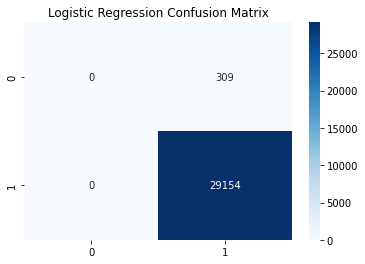

In [96]:
# Predict the labels of the test set
y_pred = clf_lr.predict(X_test)

# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt


labels = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_lr, annot=True, fmt='', cmap='Blues')

plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [97]:
# Print the spescificity
print(conf_matrix_lr[1,1]/(conf_matrix_lr[1,1] + conf_matrix_lr[0,1]))

0.989512269626311


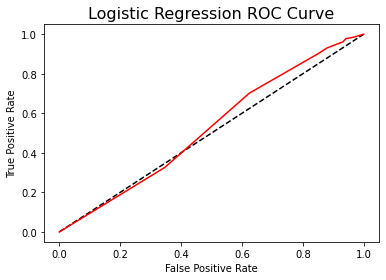

In [98]:
from sklearn.metrics import roc_curve

y_pred_prob = clf_lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show()

## 2. Random Forest

In [99]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [100]:
# Instantiate the classifier
clf_rfm = RandomForestClassifier()

# Fit to the training data
clf_rfm.fit(X_train, y_train)

# Compute accuracy
print(clf_rfm.score(X_test, y_test))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.989512269626311


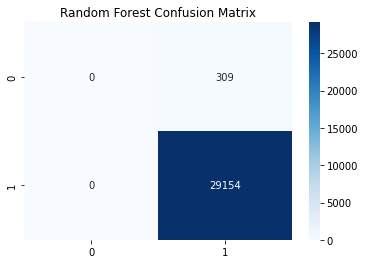

In [101]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix
conf_matrix_rfm = confusion_matrix(y_test, y_pred)

labels = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_rfm, annot=True, fmt='', cmap='Blues')

plt.title('Random Forest Confusion Matrix')
plt.show()

In [102]:
# Print the spescificity
print(conf_matrix_rfm[1,1]/(conf_matrix_rfm[1,1] + conf_matrix_rfm[0,1]))

0.989512269626311


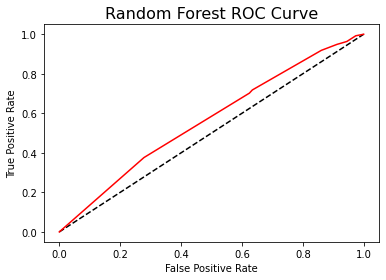

In [103]:
y_pred_prob = clf_rfm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Random Forest',color = "r")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Random Forest ROC Curve',fontsize=16)

plt.show()

## Summary:
As you can see in Random Forest ROC Curve more better than Logistic Regression ROC Curve. So, I more prefer to use Random Forest.